## Modelling the Baltic Sea using grid-based methods

In [1]:
from pygradu import gridify
import shapely.geometry
import pandas as pd
import numpy as np
import importlib

grid = gridify.area_to_grid(side_length=20000)

Original NE: POINT (31.5 66.8)
Original SW: POINT (8.5 53)
Transformed NE: (697681.2863658136, 7416224.9393330095)
Transformed SW: (-735260.4063631196, 6033964.466017238)
col_count 71
row_count 69
grid_size 4899


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 
from mpl_toolkits.basemap import Basemap

def visualize_graph(graph, grid):
    nodes = graph.original.drop_duplicates().values
    lats = []
    lons = []
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats.append(latlon[0])
        lons.append(latlon[1])


    nodes = graph.connected.drop_duplicates().values
    lats2 = []
    lons2 = []
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats2.append(latlon[0])
        lons2.append(latlon[1])

    f = plt.figure(figsize=[25,25])
    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()

    plt.plot(lons2, lats2, 'o', c='red', alpha=1, markersize=4)
    plt.plot(lons, lats, 'o', c='orange', alpha=1, markersize=4)

    plt.show()
    
def visualize_graph_connections(graph, grid):
    rows = graph.drop_duplicates().values
    lats = []
    lons = []

    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()
    
    f = plt.figure(figsize=[25,25])
    for row in rows:
        original_latlon = grid.extract_coords_lat_lon(row[0])
        connected_latlon = grid.extract_coords_lat_lon(row[1])
        lats = [original_latlon[0], connected_latlon[0]]
        lons = [original_latlon[1], connected_latlon[1]]

        plt.plot(lons, lats, alpha=1, markersize=2, linewidth=1, c='black')


    plt.show()

#### Create a sea graph with adjacent model

In [3]:
import pandas as pd


%time sea_graph = gridify.create_area_graph(grid, adjacent=True)
graph_cols = ['original', 'connected']
sea_graph = pd.DataFrame(sea_graph, columns=graph_cols)
sea_graph.head(5)

CPU times: user 50.8 ms, sys: 4 ms, total: 54.8 ms
Wall time: 54.3 ms


original  connected
0         0          1
1         0         69
2         0         70
3         1          0
4         1          2

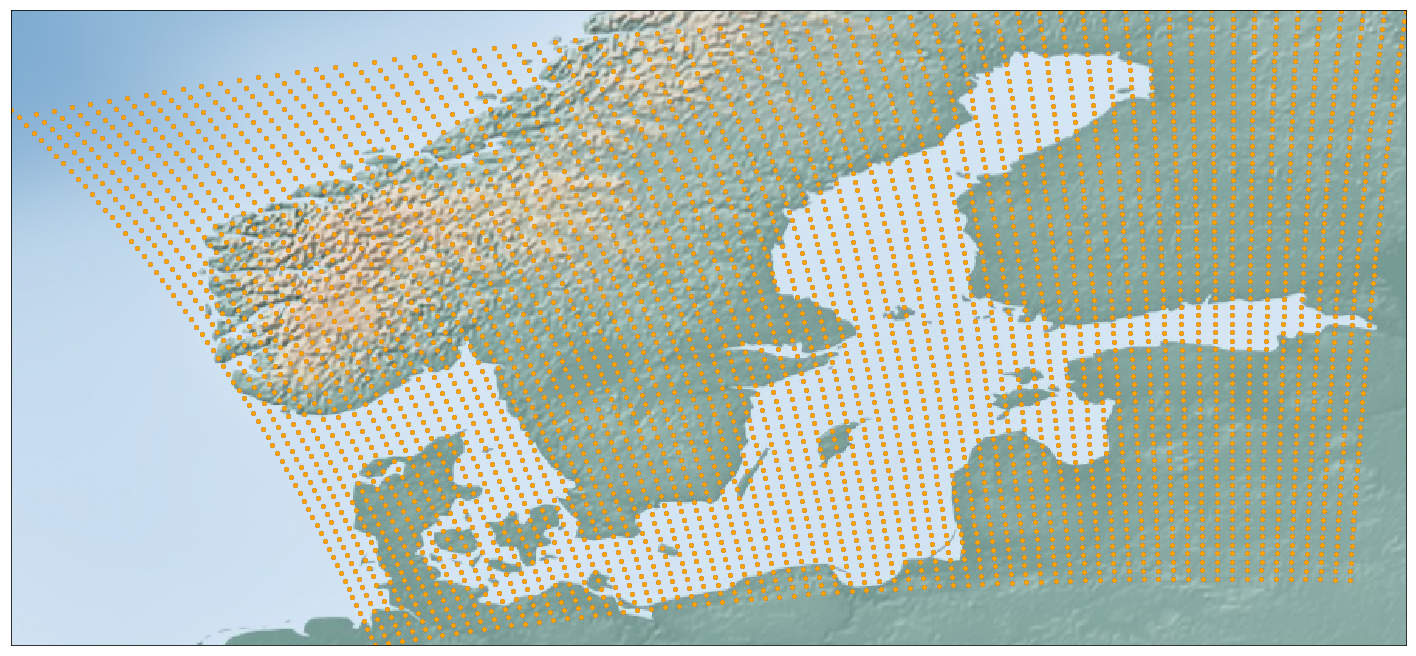

In [4]:
visualize_graph(sea_graph, grid)

In [5]:
import fiona
import pyproj
from shapely.geometry import shape
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import Point

def get_nodes_inside_area(graph, area):
    keep = []
    for node in graph.original.drop_duplicates().values:
        latlon = grid.extract_coords_lat_lon(node)
        p = Point((latlon[1], latlon[0]))
        if area.contains(p):
            keep.append(node)
    return set(keep)


def get_nodes_not_inside_area_accurate(graph, area):
    keep = []
    for node in graph.original.drop_duplicates().values:
        rowcol = grid.extract_coords(node)
        row = rowcol[0]
        col = rowcol[1]
        sw = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col], grid.rows[row]))
        se = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col] + grid.side_length, grid.rows[row]))
        nw = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col], grid.rows[row] + grid.side_length))
        ne = shapely.geometry.Point(pyproj.transform(grid.p_to, grid.p_from, grid.cols[col] + grid.side_length, grid.rows[row] + grid.side_length))
        pointlist = list([sw, se, ne, nw])

        cell = shapely.geometry.Polygon([[p.x, p.y] for p in pointlist])

        if  area.contains(cell):
            continue
        
        keep.append(node)
            
    return set(keep)

#### Filter nodes first using a rough shape of the Baltic Sea that includes a bit of the land in coastal areas.

CPU times: user 296 ms, sys: 1.01 ms, total: 297 ms
Wall time: 297 ms


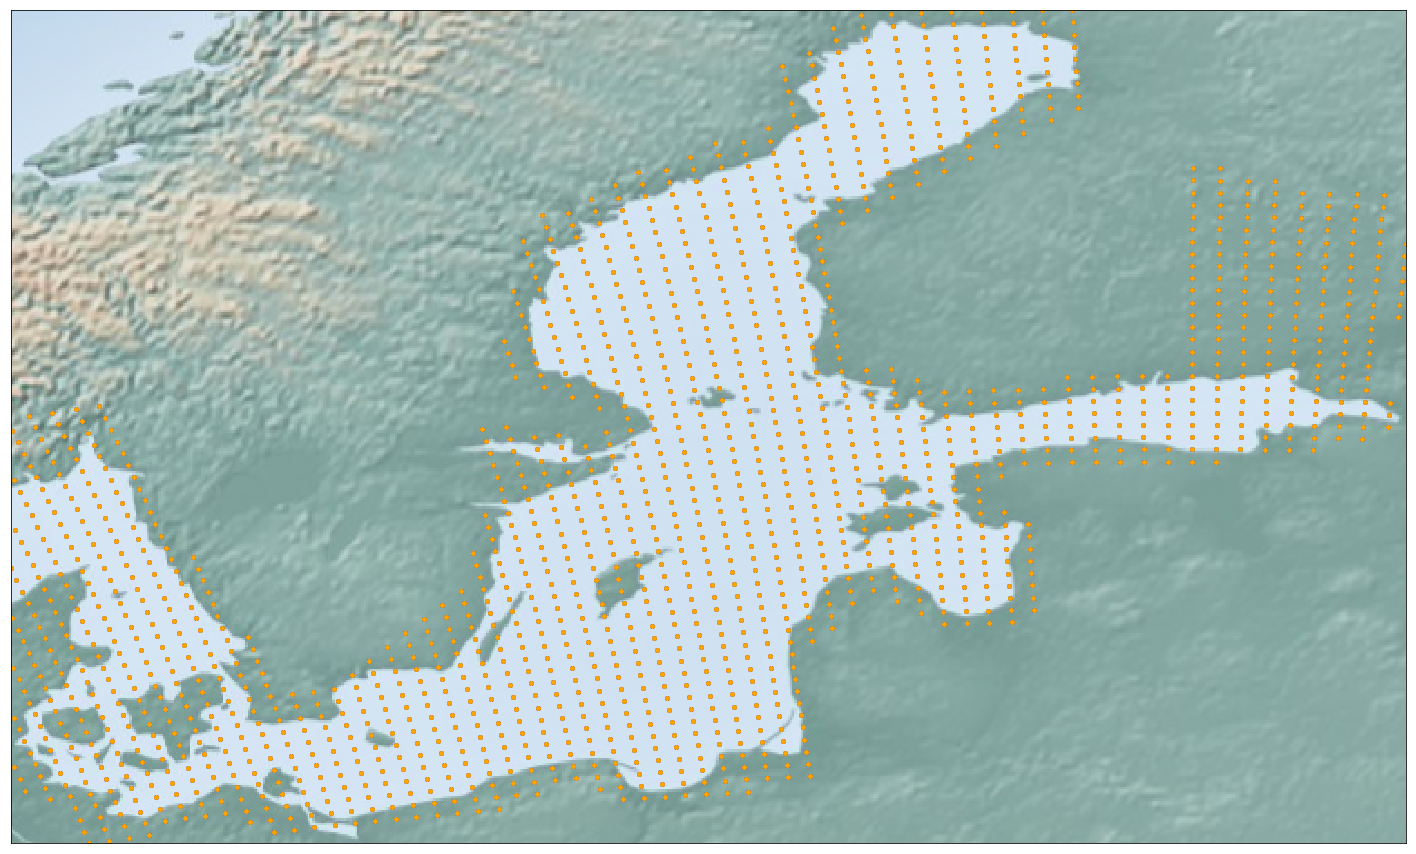

In [6]:
import json
with open('data/shapes/sea.geojson') as f:
    data = json.load(f)

sea = shape(data['features'][0]['geometry'])

%time keep = get_nodes_inside_area(sea_graph, sea)
sea_graph = sea_graph[sea_graph.original.isin(keep)]

originals = set(sea_graph.original.drop_duplicates().values)
sea_graph = sea_graph[sea_graph.connected.isin(originals)]

visualize_graph(sea_graph, grid)

#### Filter the remaining land using a much detailed (=slower) shapefile

True
CPU times: user 111 ms, sys: 12 ms, total: 123 ms
Wall time: 123 ms
True
CPU times: user 109 ms, sys: 11.1 ms, total: 120 ms
Wall time: 120 ms
CPU times: user 3min 12s, sys: 17.7 s, total: 3min 29s
Wall time: 3min 30s


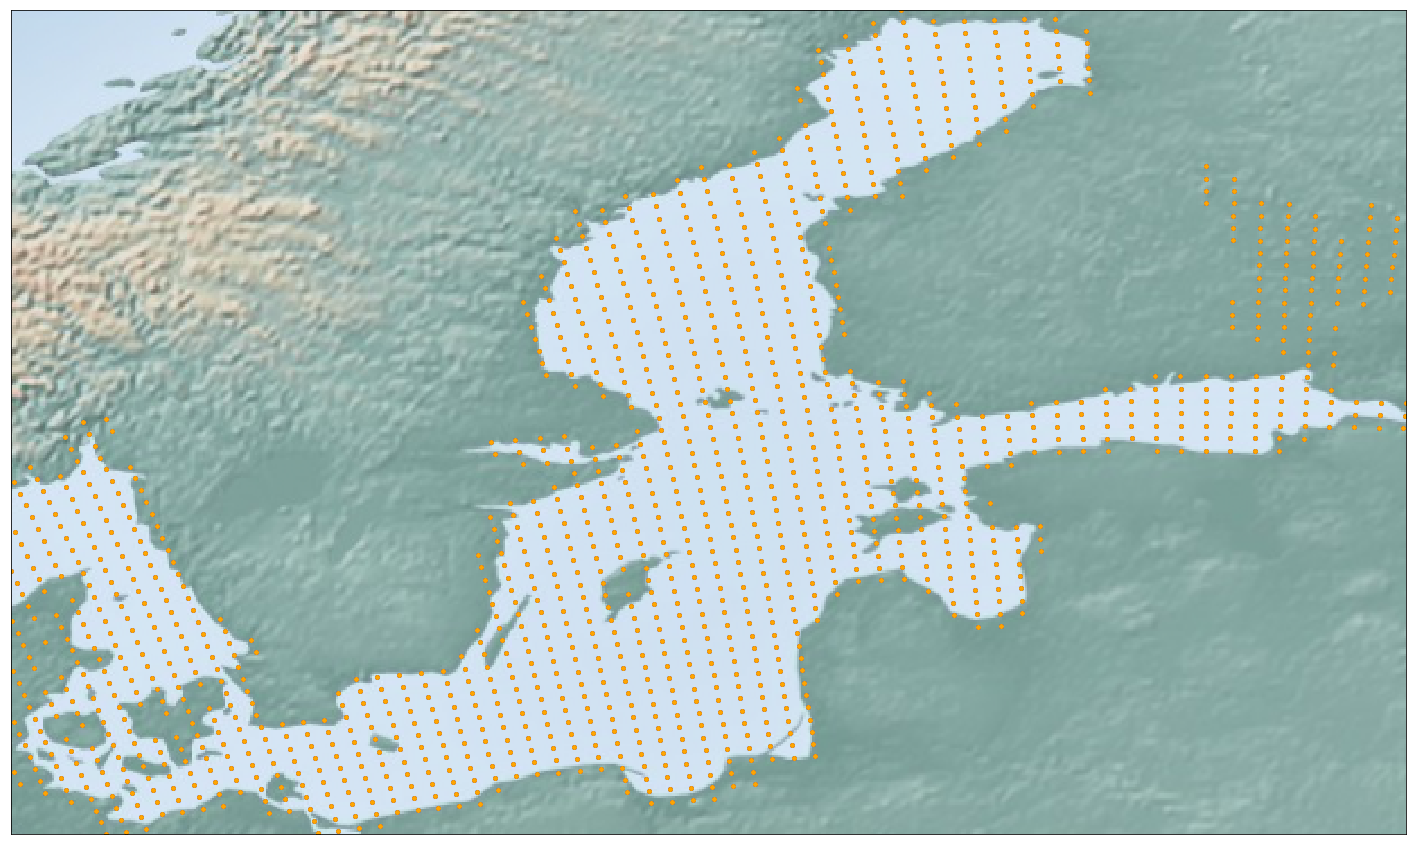

In [9]:
land = MultiPolygon([shape(pol['geometry']) for pol in fiona.open('data/shapes/detailed_land.shp')])

%time print(land.contains(Point(30, 53)))
%time print(land.contains(Point(14.584798172002538,53.92132432670449)))

%time keep = get_nodes_not_inside_area_accurate(sea_graph, land)
sea_graph = sea_graph[sea_graph.original.isin(keep)]

originals = set(sea_graph.original.drop_duplicates().values)
sea_graph = sea_graph[sea_graph.connected.isin(originals)]

visualize_graph(sea_graph, grid)

#### You can also create the sea graph with only one command by providing the land (=filtered geom) to gridify.create_sea_graph function

In [21]:
land = MultiPolygon([shape(pol['geometry']) for pol in fiona.open('data/shapes/detailed_land.shp')])
%time print(land.contains(Point(30, 53)))
%time print(land.contains(Point(20.8464268,60.8670341)))

%time sea_graph = gridify.create_sea_graph(grid, adjacent=True, exclude_geom=land)

graph_cols = ['original', 'connected']
base_graph = pd.DataFrame(sea_graph, columns=graph_cols)
base_graph.head(5)

True
CPU times: user 109 ms, sys: 9.33 ms, total: 118 ms
Wall time: 118 ms
False
CPU times: user 115 ms, sys: 10.9 ms, total: 126 ms
Wall time: 126 ms
CPU times: user 10min 10s, sys: 53.5 s, total: 11min 3s
Wall time: 11min 9s


original  connected
0        18         17
1        18         19
2        18         86
3        18         87
4        18         88

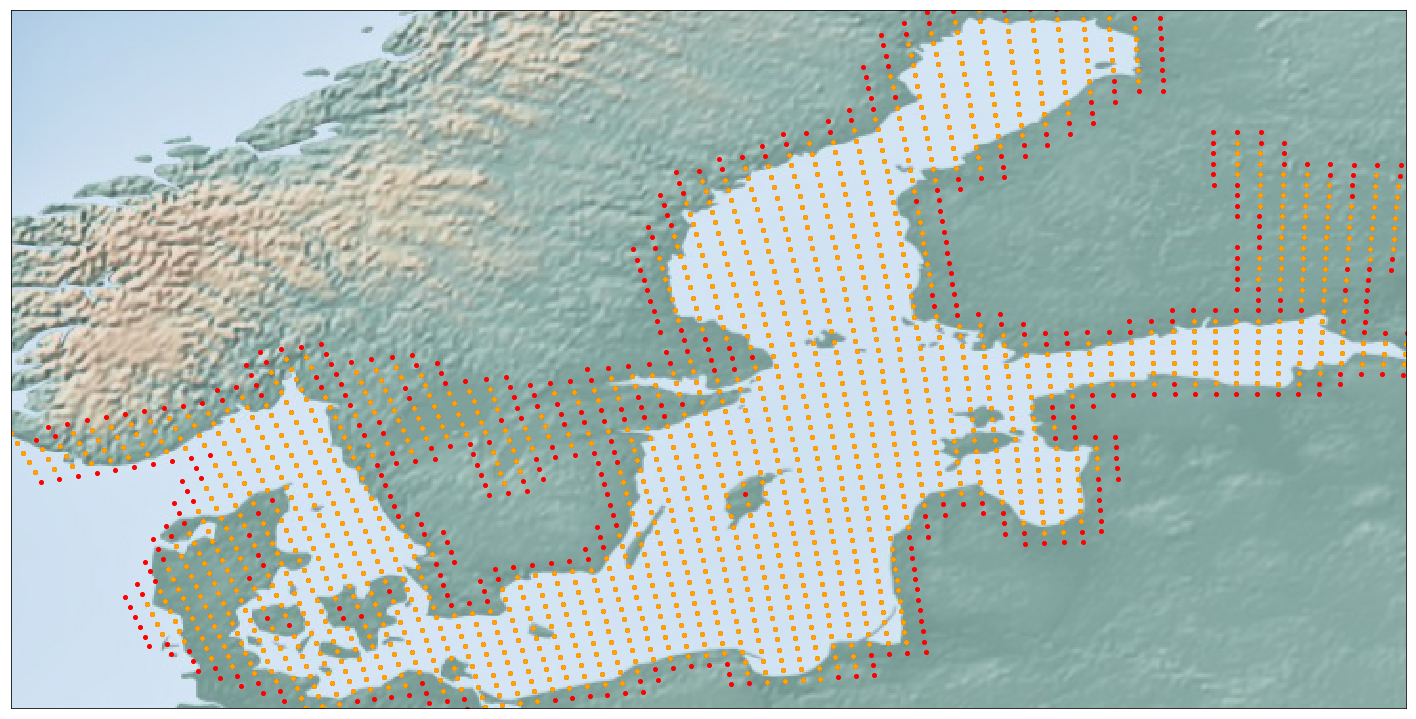

In [22]:
visualize_graph(base_graph, grid)

#### Remove impossible connections

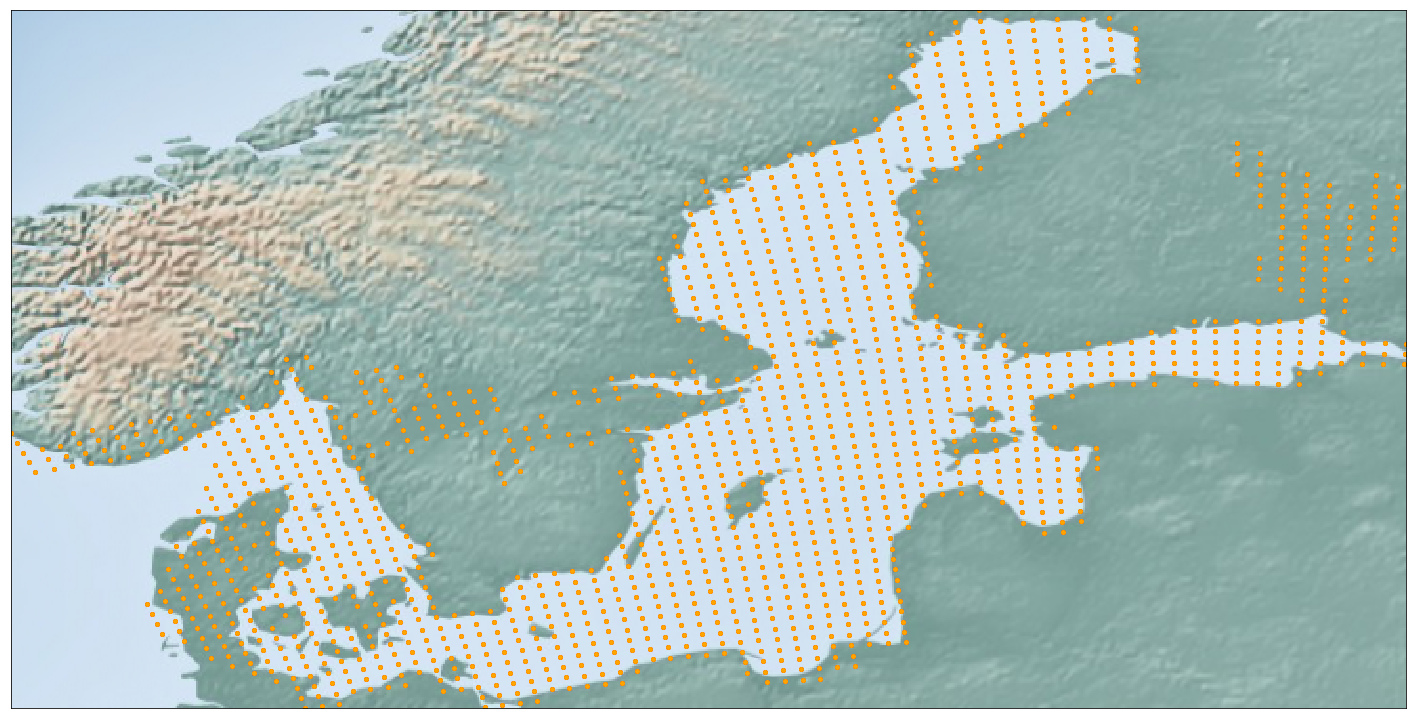

In [23]:
originals = set(base_graph.original.drop_duplicates().values)
base_graph = base_graph[base_graph.connected.isin(originals)]
visualize_graph(base_graph, grid)

#### Removing nodes on land

False
CPU times: user 435 µs, sys: 456 µs, total: 891 µs
Wall time: 1.14 ms
True
CPU times: user 391 µs, sys: 165 µs, total: 556 µs
Wall time: 417 µs


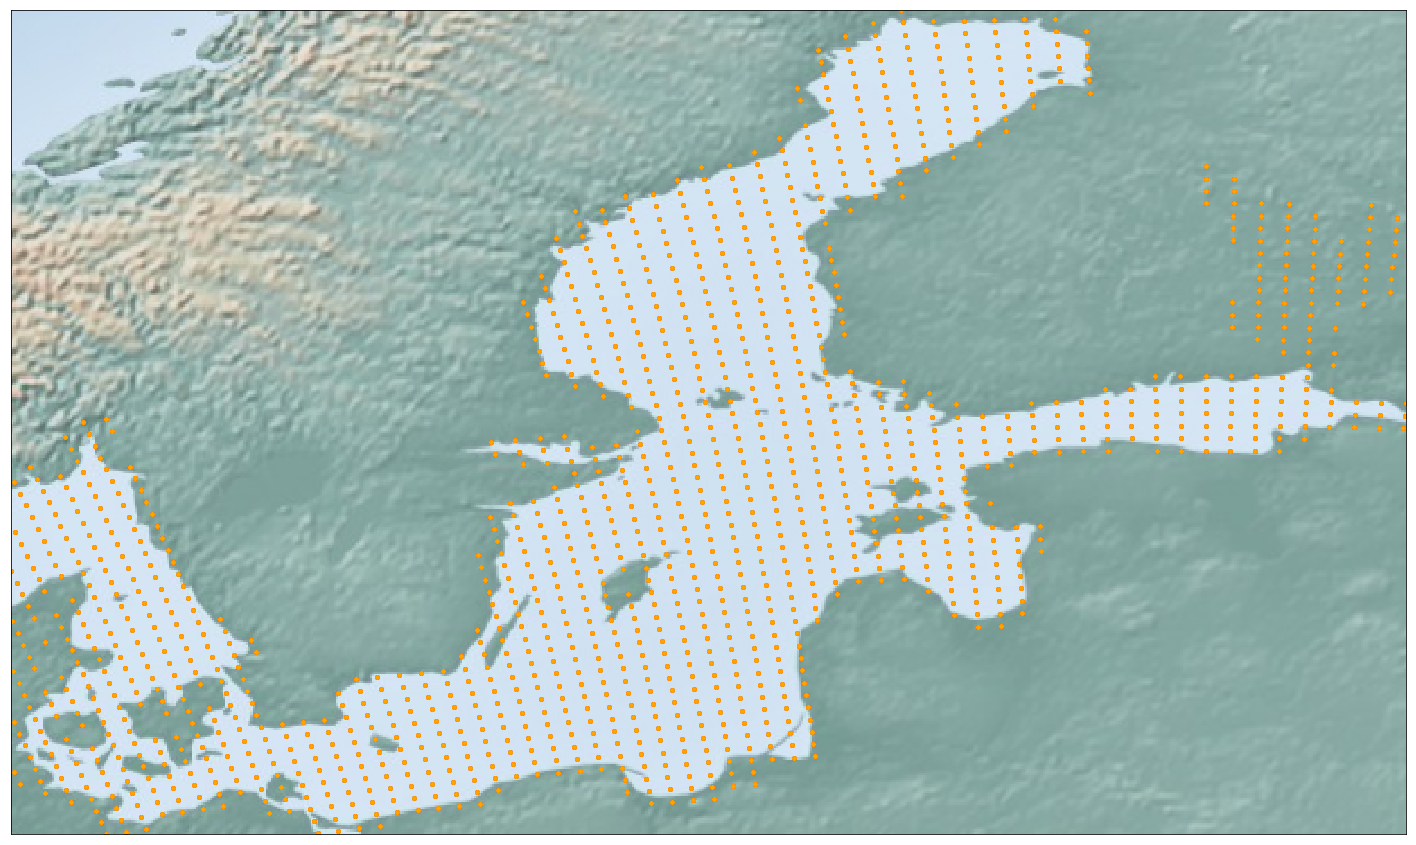

In [24]:
import json
with open('data/shapes/sea.geojson') as f:
    data = json.load(f)

sea = shape(data['features'][0]['geometry'])
%time print(sea.contains(Point(30, 53)))
%time print(sea.contains(Point(14.584798172002538,53.92132432670449)))

keep = []
for node in base_graph.original.drop_duplicates().values:
    latlon = grid.extract_coords_lat_lon(node)
    p = Point((latlon[1], latlon[0]))
    if sea.contains(p):
        keep.append(node)
keep = set(keep)
base_graph = base_graph[base_graph.original.isin(keep)]

originals = set(base_graph.original.drop_duplicates().values)
base_graph = base_graph[base_graph.connected.isin(originals)]

visualize_graph(base_graph, grid)

#### Visualize a neighbors of a single node

In [30]:
counts = base_graph.groupby(['original']).size()
counts = counts.to_frame().reset_index()
counts.columns = ['original', 'neighbors']
counts.neighbors.max()
counts[counts.neighbors == 8].tail(10)

original  neighbors
1441      4191          8
1442      4192          8
1443      4193          8
1444      4194          8
1445      4195          8
1449      4259          8
1450      4260          8
1451      4261          8
1452      4262          8
1453      4263          8

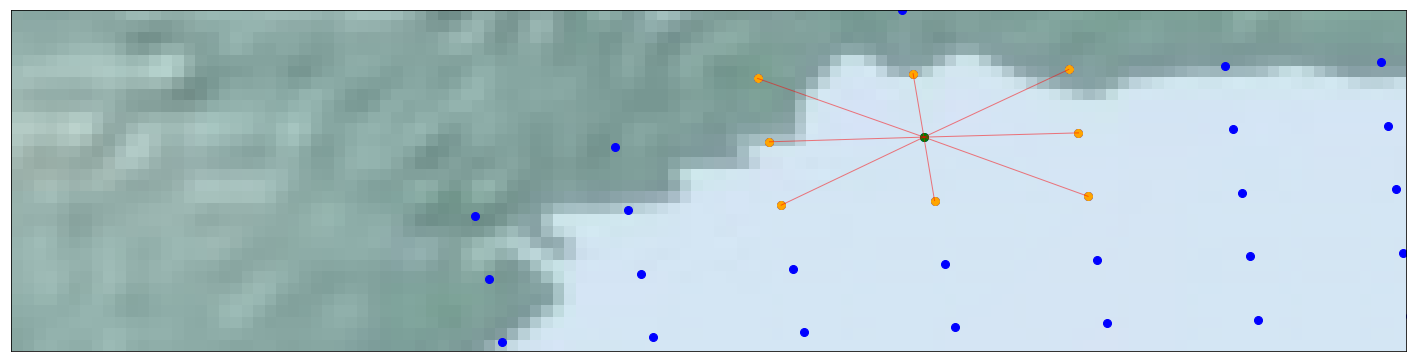

In [39]:
nodes = base_graph.original.drop_duplicates().values
lats = []
lons = []
for node in nodes:
    latlon = grid.extract_coords_lat_lon(node)
    lats.append(latlon[0])
    lons.append(latlon[1])

f = plt.figure(figsize=[25,25])

m = Basemap(llcrnrlon = 20,llcrnrlat = 65, urcrnrlon = 24,
           urcrnrlat = max(lats),
           resolution='l')
m.shadedrelief()

plt.plot(lons, lats, 'o', c='blue', alpha=1, markersize=8)

start_node = 4259
nodes = base_graph[base_graph.original == start_node].connected.values

start_latlon = grid.extract_coords_lat_lon(start_node)
plt.plot(start_latlon[1], start_latlon[0], 'o', c='green', alpha=1, markersize=8)
for node in nodes:
    lats = []
    lons = []
    lats.append(start_latlon[0])
    lons.append(start_latlon[1])
    
    latlon = grid.extract_coords_lat_lon(node)
    lats.append(latlon[0])
    lons.append(latlon[1])
    
    plt.plot(lons[1], lats[1], 'o', c='orange', alpha=1, markersize=8)
    plt.plot(lons, lats, c='red', alpha=0.5, markersize=10, linewidth=1)

plt.show()